file saved to niebieski-szlak-rowerowy-ciekoty-wola-kopcowa.csv


OSError: Address 'http://127.0.0.1:8050' already in use.
    Try passing a different port to run_server.

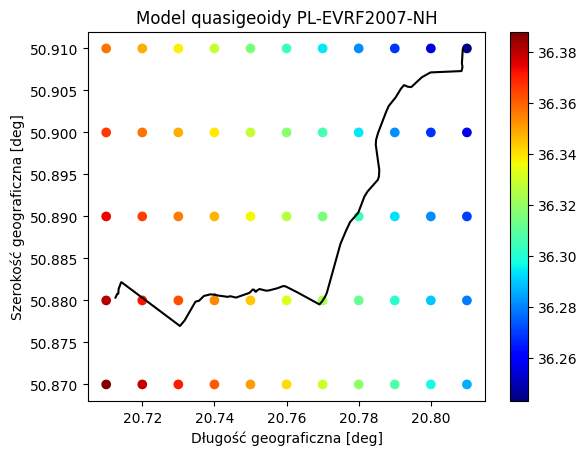

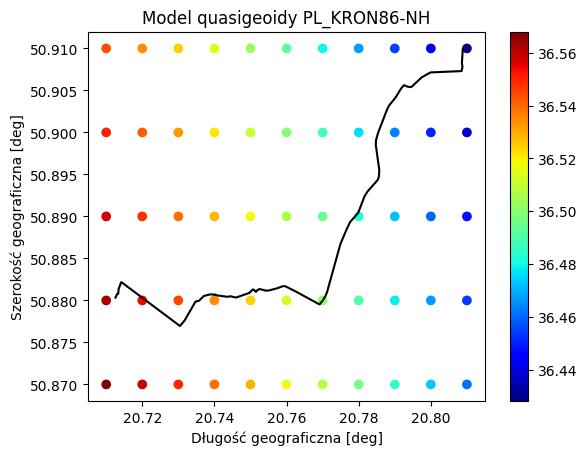

In [1]:
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from funkcje import gpx2df, save_df, read_route_df
from dash import Dash, dcc, html, Input, Output, State

# PL-KRON86
plik = 'niebieski-szlak-rowerowy-ciekoty-wola-kopcowa.gpx'

gpx2df(plik, 'niebieski-szlak-rowerowy-ciekoty-wola-kopcowa.csv')
df = read_route_df('niebieski-szlak-rowerowy-ciekoty-wola-kopcowa.csv')

a = 6378137.0
e2 = 0.00669438002290

# Phi, lam, h -> X, Y, Z
def orto(p, l, h):
    N = a / (np.sqrt(1 - e2 * np.sin(l) * np.sin(l)))
    X = (N + h) * np.cos(p) * np.cos(l)
    Y = (N + h) * np.cos(p) * np.sin(l)
    Z = (N * (1 - e2) + h) * np.sin(p)
    return([X, Y, Z])

center_lon = np.mean(df.longitude)
center_lat = np.mean(df.latitude)

phis = df['latitude']
lams = df['longitude']

dists = [0]

# Transformacja współrzędnych i obliczenie odległości
for i, _ in enumerate(phis):
    if i < len(phis) - 1:
        phi1 = phis[i]
        lam1 = lams[i]
        phi2 = phis[i+1]
        lam2 = lams[i+1]

        xyz1 = orto(np.deg2rad(phi1), np.deg2rad(lam1), 200)
        xyz2 = orto(np.deg2rad(phi2), np.deg2rad(lam2), 200)
        dxyz = np.array(xyz2) - np.array(xyz1)

        d = np.linalg.norm(dxyz)
        dists.append(d)

df['distance'] = dists
df['distances'] = df['distance'].cumsum()

def zmniejszenieSiatki(model, phis, lams):
    max_phi = np.max(phis)
    min_phi = np.min(phis)
    max_lam = np.max(lams)
    min_lam = np.min(lams)

    ind_phi = np.logical_and(model[:, 0] >= (min_phi - 0.01), model[:, 0] <= (max_phi + 0.01))
    ind_lam = np.logical_and(model[:, 1] >= (min_lam - 0.01), model[:, 1] <= (max_lam + 0.01))

    indeksy = np.logical_and(ind_phi, ind_lam)
    model = model[indeksy, :]

    return(model)

# Model quasigeoidy PL-EVRF2007-NH
pl_evrf = np.genfromtxt('Model_quasi-geoidy-PL-geoid2021-PL-EVRF2007-NH.txt', skip_header = 1)
model1 = zmniejszenieSiatki(pl_evrf, phis, lams)

model_evrf, ax = plt.subplots()
im = ax.scatter(model1[:, 1], model1[:, 0], c = model1[:, 2], cmap = 'jet')
ax.plot(lams, phis, c = 'black')
ax.set_xlabel('Długość geograficzna [deg]')
ax.set_ylabel('Szerokość geograficzna [deg]')
ax.set_title('Model quasigeoidy PL-EVRF2007-NH')
model_evrf.colorbar(im)

# Model quasigeoidy PL-KRON86-NH
pl_kron86 = np.genfromtxt('siatka_gugik-geoid2011-PL-KRON86-NH.txt', skip_header = 1)
model2 = zmniejszenieSiatki(pl_kron86, phis, lams)

model_kron86, ax = plt.subplots()
im = ax.scatter(model2[:, 1], model2[:, 0], c = model2[:, 2], cmap = 'jet')
ax.plot(lams, phis, c = 'black')
ax.set_xlabel('Długość geograficzna [deg]')
ax.set_ylabel('Szerokość geograficzna [deg]')
ax.set_title('Model quasigeoidy PL_KRON86-NH')
model_kron86.colorbar(im)

def interpolacja(model2, phi, lam, grid_step = 0.01):
    ind_phi = np.logical_and(model2[:, 0] >= (phi - grid_step), model2[:, 0] < (phi + grid_step))
    ind_lam = np.logical_and(model2[:, 1] >= (lam - grid_step), model2[:, 1] < (lam + grid_step))

    indeksy = np.logical_and(ind_phi, ind_lam)
    model3 = model2[indeksy, :]

    if np.size(model3) != 12:
        model3 = np.vstack((model3, model3))

    (y1, x1, Q11), (_y1, x2, Q21), (y2, _x1, Q12), (_y2, _x2, Q22) = model3
    x = lam
    y = phi
    R1 = Q11 + (Q21 - Q11) /  (x2 - x1) * (x - x1)
    R2 = Q12 + (Q22 - Q12) /  (x2 - x1) * (x - x1)

    P = R1 + (R2 - R1) / (y2 - y1) * (y - y1)
    model4 = np.array([y, x, P])

    return P

dzety_elip = []
dzety_evrf = []

for phi, lam in zip(phis, lams):
    dzeta1 = interpolacja(model1, phi, lam, grid_step = 0.01)
    dzeta2 = interpolacja(model2, phi, lam, grid_step = 0.01)
    dzety_elip.append(dzeta2)
    dzety_evrf.append(dzeta1)

# Obliczenie wysokości elipsoidalnych
df['ellipsoid'] = df['elevation'] + np.array(dzety_elip)

# Obliczenie wysokości normalnych w układzie Amsterdam (PL-EVRF2007)
df['hel'] = df['ellipsoid'] - np.array(dzety_evrf)

# Profil wysokościowy PL-KRON86-NH
elev = df['elevation']
profil = go.Figure(data = go.Scatter(
    x = df['distances'],
    y = elev,
    mode = 'lines',
    marker = dict(size = 7, color = 'green'),
    fill = 'tozeroy',
    fillcolor = 'rgba(0, 128, 0, 0.4)'
))
profil.update_layout(
    title = 'Profil dla wysokości normalnych Kronsztad 86',
    xaxis_title = 'Dystans [m]', 
    yaxis_title = 'Wysokość [m]',
    template = 'plotly_white',
    yaxis_range = [np.min(elev) - 10, np.max(elev) + 10]
)

# Profil wysokościowy elipsoidalny
elev_el = df['ellipsoid']
profil_el= go.Figure(data = go.Scatter(
    x = df['distances'], 
    y = elev_el,
    mode = 'lines',
    marker = dict(size = 7, color = 'red'),
    fill = 'tozeroy',
    fillcolor = 'rgba(255, 0, 0, 0.4)'
))
profil_el.update_layout(
    title = 'Profil dla wysokości elipsoidalnych',
    xaxis_title = 'Dystans [m]', 
    yaxis_title = 'Wysokość [m]',
    template = 'plotly_white',
    yaxis_range = [np.min(elev_el) - 10, np.max(elev_el) + 10],
    hovermode = 'x'
)

# Profil wysokościowy PL-EVRF2007-NH
elev_no = df['hel']
profil_no = go.Figure(data = go.Scatter(
    x = df['distances'], 
    y = elev_no,
    mode = 'lines',
    marker = dict(size = 7, color = 'orange'),
    fill = 'tozeroy',
    fillcolor = 'rgba(255, 165, 0, 0.4)'
))
profil_no.update_layout(
    title = 'Profil dla wysokości normalnych Amsterdam',
    xaxis_title = 'Dystans [m]', 
    yaxis_title = 'Wysokość [m]',
    template = 'plotly_white',
    yaxis_range = [np.min(elev_no) - 10, np.max(elev_no) + 10],
    hovermode = 'x'
)

df['diff'] = df['hel'] - df['elevation']

# Różnice wysokości
dif = df['diff']
profil_diff = go.Figure(data = go.Scatter(
    x = df['distances'],
    y = dif,
    mode = 'lines',
    marker = dict(size = 7, color = 'green'),
    fill = 'tozeroy',
    fillcolor = 'rgba(0, 128, 0, 0.4)'
))
profil_diff.update_layout(
    title = 'Różnice wysokości PL-EVRF2007 a PL-KRON86',
    xaxis_title = 'Dystans [m]',
    yaxis_title = 'Różnica wysokości [m]',
    template = 'plotly_white',
    yaxis_range = [np.min(dif) - 0.01, np.max(dif) + 0.01],
    hovermode = 'x'
)

def create_line_segment(lat1, lon1, lat2, lon2, color):
    return go.Scattermapbox(
        lat=[lat1, lat2],
        lon=[lon1, lon2],
        mode='lines',
        line=dict(width=4, color=color),
        hoverinfo='skip'
    )

elev_min = np.min(df['hel'])
elev_max = np.max(df['hel'])
colors = px.colors.sequential.YlOrRd

# Mapa trasy rowerowej
mapa = go.Figure(data = go.Scattermapbox(
    lat = df.latitude, 
    lon = df.longitude, 
    mode = 'lines',
    marker = dict(
        size=15,
        color ='#455173'
    )
))

for i in range(len(df) - 1):
    lat1, lon1, elev1 = df.iloc[i][['latitude', 'longitude', 'hel']]
    lat2, lon2, elev2 = df.iloc[i+1][['latitude', 'longitude', 'hel']]
    color = colors[int((elev1 - elev_min) / (elev_max - elev_min) * (len(colors) - 1))]
    mapa.add_trace(create_line_segment(lat1, lon1, lat2, lon2, color))

mapa.update_layout(
    title = 'Mapa szlaku rowerowego',
    mapbox_style = 'open-street-map', 
    mapbox_center_lon = center_lon,
    mapbox_center_lat = center_lat,
    mapbox_zoom = 11,
    showlegend = False
)
mapa.add_trace(go.Scattermapbox(
    lat = [df.latitude[0]],
    lon = [df.longitude[0]],
    mode = 'markers + text',
    marker = dict(size = 10, color = '#455173'),
    text = ['Start'],
    textposition = 'bottom right',
    textfont = dict(size = 15)
))
mapa.add_trace(go.Scattermapbox(
    lat = [df.latitude[len(df.latitude)-1]],
    lon = [df.longitude[len(df.longitude)-1]],
    mode = 'markers + text',
    marker = dict(size = 10, color = '#455173'),
    text = ['Koniec'],
    textposition = 'bottom right',
    textfont = dict(size = 15)
))

df['hel_normalized'] = (df['hel'] - df['hel'].min()) / (df['hel'].max() - df['hel'].min())
df['hel_color'] = df['hel_normalized'].apply(lambda x: colors[int(x * (len(colors) - 1))])

distances_col = [f"{df.distances[i]:.3f}" for i in range(len(df.distances))]
elevation_col = [f"{df.elevation[i]:.3f}" for i in range(len(df.elevation))]
ellipsoid_col = [f"{df.ellipsoid[i]:.3f}" for i in range(len(df.ellipsoid))]
hel_col = [f"{df.hel[i]:.3f}" for i in range(len(df.hel))]
diff_col = [f"{df['diff'][i]:.3f}" for i in range(len(df['diff']))]

# Tabela danych
tab = go.Figure(data = [go.Table(
    header=dict(values=['szerokość geograficzna [°]', 'długość geograficzna [°]',   'odległość od startu [m]', 'wysokość normalna Kronsztad 86 [m]', 'wysokość elipsoidalna [m]', 'wysokość normalna Amsterdam [m]', 'różnica wysokości [m]'], 
                fill_color='#E3EFF2', align='center', font_size=13, font_color='black'),
    cells=dict(values=[df.latitude, df.longitude, distances_col, elevation_col, ellipsoid_col, hel_col, diff_col], 
               fill_color=[df['hel_color']], font_color='black', align='center', font_size=12))
])

stylesheet = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
app = Dash(__name__)

styles = {
    'full_fig': {
        'width': '100%',
        'height': '80vh',
        'float': 'center'
    },
    'left_fig': {
        'width': '60%',
        'height': '80vh',
        'float': 'left',
        'padding': '0px',
        'margin': '0px'
    },
    'right_fig': {
        'width': '40%',
        'height': '60vh',
        'float': 'right',
        'margin-top': '5vh',
    },
    'info_style': {
        'width': '15%', 'height': '25vh',
        'textAlign': 'left',
        'font-size': '16px',
        'padding': '30px',
        'float': 'right',
        'background-color': '#E3EFF2',
        'border-radius': '20px',
        'margin-right': '15px',
        'border': '4px outset #2D364D',
        'font-family': 'DM Sans, sans-serif'
    },
    'dropdown_style': {
        'width': '40%', 'height': '5vh',
        'margin-left': '10px',
        'float': 'left',
        'font-size': '18px',
        'font-family': 'DM Sans, sans-serif'
    },
    'header': {
        'height': '5vh', 'float': 'center', 
        'text-align': 'center', 'color': '#2D364D',
        'padding': '10px',
        'font-family': 'DM Sans, sans-serif'
    }
}

app.layout = html.Div([
    html.H1('Niebieski szlak rowerowy Ciekoty - Wola Kopcowa', 
            style = styles['header']),
    dcc.Dropdown(
        id='graph-selector',
        options=[
            {'label': 'Mapa trasy', 'value': 'mapa'},
            {'label': 'Profil wysokościowy na elipsoidzie', 'value': 'elev'},
            {'label': 'Profil wysokościowy dla wysokości normalnych', 'value': 'elev2'},
            {'label': 'Różnica wysokości PL-EVRF2007 a PL-KRON86', 'value': 'diff'},
            {'label': 'Tabela danych', 'value': 'tabela'}
        ],
        value = 'mapa',
        style = styles['dropdown_style']
    ),
    dcc.Graph(
        id='displayed-graph', 
        style = styles['left_fig']
    ),
    html.Div(id='additional-info'),
    html.Div(id='additional-info2'),
    html.Div(id='right-side', style = styles['right_fig']),
], 
style = {'width': '98%', 'height': '100vh'})

# Aktualizacja wyświetlanego wykresu
@app.callback(
    Output('displayed-graph', 'figure'),
    [Input('graph-selector', 'value')]
)
def update_graph(selected_graph):
    if selected_graph == 'mapa':
        return mapa
    elif selected_graph == 'elev':
        return profil_el
    elif selected_graph == 'elev2':
        return profil_no
    elif selected_graph == 'diff':
        return profil_diff
    elif selected_graph == 'tabela':
        return tab
    else:
        return mapa

# Aktualizacja informacji o trasie
@app.callback(
    Output('additional-info2', 'children'),
    [Input('displayed-graph', 'clickData')],
    [State('graph-selector', 'value')]
)
def display_data(clickData, selected_graph):
    total_distance = df['distances'].iloc[-1]
    min_elevation = df['hel'].min()
    max_elevation = df['hel'].max()
    return html.Div([
        html.H3('Informacje o trasie'),
        html.P(f'Dystans:                {total_distance:.3f} m'),
        html.P(f'Minimalna wysokość:     {min_elevation:.3f} m'),
        html.P(f'Maksymalna wysokość:    {max_elevation:.3f} m')
    ], style=styles['info_style'])

# Aktualizacja informacji o punkcie
@app.callback(
    Output('additional-info', 'children'),
    [Input('displayed-graph', 'clickData')],
    [State('graph-selector', 'value')]
)
def display_click_data(clickData, selected_graph):
    if clickData is None:
        return html.Div([
            html.H3('Informacje o punkcie'),
            html.P('kliknij na wykres główny')
        ], style = styles['info_style'])
    
    elif selected_graph == 'mapa':
        lon = clickData['points'][0]['lon']
        lat = clickData['points'][0]['lat']
        nr = clickData['points'][0]['pointNumber']

        text1 = f'Współrzędne:                      {lat}, {lon}'
        text2 = f'Wysokość normalna dana:           {f"{df.elevation[nr]:.3f} m"}'
        text3 = f'Wysokość elipsoidalna:            {f"{df.ellipsoid[nr]:.3f} m"}'
        text4 = f'Wysokość normalna:                {f"{df.hel[nr]:.3f} m"}'
        text5 = f'Różnica wysokości PL-EVRF2007 a PL-KRON86:  {f"{(df.hel[nr] - df.elevation[nr]):.3f} m"}'
            
        return html.Div([
            html.H3('Informacje o punkcie'),
            html.P(text1),
            html.P(text2),
            html.P(text3),
            html.P(text4),
            html.P(text5)
        ],
        style = styles['info_style'])
    elif selected_graph == 'elev' or selected_graph == 'elev2' or selected_graph == 'diff':
        nr = clickData['points'][0]['pointNumber']
        text1 = f'Dystans:                  {f"{df.distances[nr]:.3f} m"}'
        text2 = f'Wysokość normalna dana:   {f"{df.elevation[nr]:.3f} m"}'
        text3 = f'Wysokość elipsoidalna:    {f"{df.ellipsoid[nr]:.3f} m"}'
        text4 = f'Wysokość normalna:        {f"{df.hel[nr]:.3f} m"}'
        text5 = f'Różnica wysokości PL-EVRF2007 a PL-KRON86:  {f"{(df.hel[nr] - df.elevation[nr]):.3f} m"}'

        return html.Div([
            html.H3('Informacje o punkcie'),
            html.P(text1),
            html.P(text2),
            html.P(text3),
            html.P(text4),
            html.P(text5)
        ],
        style = styles['info_style'])
    else:
        return {}

# Aktualizacja prawego wykresu
@app.callback(
    Output('right-side', 'children'),
    [Input('graph-selector', 'value')]
)
def update_right_side(selected_graph):
    if selected_graph == 'mapa':
        return dcc.Graph(figure=profil_no)
    else:
        return dcc.Graph(figure=mapa)

# Po uruchomeniu aplikacji, wejść na wyświetlany link
if __name__ == '__main__':
    app.run(debug = True)
